### First Heuristic - Preliminary implementation

#### Description
If a deposit address matches a withdraw address, then it is trivial to link the two addresses. Therefore, the deposit address needs to be removed from all the other withdraw addresses’ anonymity set. 
If a number $N$ of deposits with a same address $add1$, and a number $M$ ($M < N$) of withdraws with that same aaddress are detected, then a number $M - N$ of deposit transactions must be removed from the anonimity set of all the other withdraw transactions.


In [1]:
# Import relevant packages.

using DataFrames
using CSV

In [66]:
# Environment settings for the notebook.
ENV["LINES"]=20
ENV["COLUMNS"]=10000

10000

In [65]:
# Load withdraw and deposit transactions data.

withdraw_transactions_df = CSV.read("../data/tornado_withdraw_df.csv", DataFrame)
withdraw_transactions_df["recipient_address"] = lowercase.(withdraw_transactions_df["recipient_address"])

deposit_transactions_df = CSV.read("../data/deposit_transactions.csv", DataFrame);

In [4]:
withdraw_transactions_df

,Column1,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,input,receipt_cumulative_gas_used,receipt_gas_used,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price,recipient_address
,Int64,String,Int64,Int64,String,String,Int64,Int64,Int64,String,Int64,Int64,Missing,Missing,Int64,String,Int64,String,Missing,Missing,Missing,Int64,String
1,0,0x8211d6815cdd607a1f8a0d5db08b3cd0121d6df4c6f5b52023788883e6fe7a97,0,54,0x00058bf70d45aa62a493e5fc596974edde903324,0x910cbd523d972eb0a6f4cae4618ad62622b39dbf,0,421760,37000000000,0x21a0adb600000000000000000000000000000000000000000000000000000000000000e0262c5b75219fb59b3a6e535d04d7f4ddf7b8ffd3236263babebaf0e352717db22782f28dda1bfccf8b1c59d0595a400214a32bdad8dcd3b1753a4013a8d6555300000000000000000000000000058bf70d45aa62a493e5fc596974edde90332400000000000000000000000000058bf70d45aa62a493e5fc596974edde9033240000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000055def7d206642ea94235420978ff0ea81fd15e7d8d7f9ab2b261bf980bb1d321e78994d9d0c49408a22a7481681f7945d8be26efc23e183a412169da7af4422fb173319129d37b7db5df1dbb9f6f5db60f1e5f81ab07f4f030dac1ce83999e2cba949a94b22d1f4af9749f46306db16ea555cea7412951222f7fc5716eae5d0a358bd5d1527136137ec436cb67149a2ca998342359f4f2bc8904d1ae5b520522b4b6dbcdfec5217e30fcd60797cf601bd77b3b0e9157e2e2331408b2553a340e4c89700723498c6e30c1ca67a9a5d0e64a3013845f26299969e7c824aacf6e22ac16d06453342296443d0c7a37bea887ff98cb0888481525a0cbc761754d9d,2727540,321760,missing,missing,1,2020-07-16 04:21:43 UTC,10468347,0x97002c5d89010843864301297092eb60b3d902f1850d863717db7ec768e7896e,missing,missing,missing,37000000000,0x00058BF70d45AA62A493E5FC596974EdDe903324
2,1,0xcc8746c16a2bf379e8319b7c190676b77508f09f7a9cec13dd5f77514f446034,800,56,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,0,423207,13000000000,0x21a0adb600000000000000000000000000000000000000000000000000000000000000e00a52cba850f4ad215648a969675fe4f4b02d6ddae38a189e81396e742962928527e852fdad1aed9326a692b63973cf72c5d6b4a13a6c54599780e870a7c304c80000000000000000000000000039f22efb07a647557c7c5d17854cfd6d489ef30000000000000000000000000039f22efb07a647557c7c5d17854cfd6d489ef300000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010022b904e7729cc7af2d50170a9b57934740815876a1f96a43c832ece57ce95dae2d98b39685cb87a18d38e29c20271506d7103bc391b490a7d524c76c91ff4f9518442626bafb9d4d95c507fa0d3b4a19f34c457bb22dab65432c7c1cd90742200323a69be5b17c37f876c8c212625f955e69151f9b5f695899743a9798f11959226c0dfbd8cf0db70ac928850726479a0a741e0b26ad81fe1d4415d22ce258732c1a9adf37aa06373fea66b14dad706bd08c951d497b3ef8ca5c550f942cc726140dbbb541564c78a4daa44bd5ec69b192b8acf8df2ed2d86386b17abfbf991d1405c2269265226205195dd90d96119383d494b261c31e19b7b6de46ffcf9c1b,3032779,323207,missing,missing,1,2019-12-16 20:06:53 UTC,9117186,0x8dc6ade4626b61074d088ba600ddcc2686bdc1795681440ce9a86cc6dbdc4dac,missing,missing,missing,13000000000,0x0039F22efB07A647557C7C5d17854CFD6D489eF3
3,2,0x9bb7303af6ce69085abc3d9f4f5b7884a90023fd6e5925cb6ffed9737ebff78c,799,51,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,0,423207,13000000000,0x21a0adb600000000000000000000000000000000000000000000000000000000000000e00a52cba850f4ad215648a969675fe4f4b02d6ddae38a189e81396e742962928525ff03d81abc80888bb6e8bd553e9c47e8e765bd4a0ea9e96dc179ea0d2aad4f0000000000000000000000000039f22efb07a647557c7c5d17854cfd6d489ef30000000000000000000000000039f22efb07a647557c7c5d17854cfd6d489ef3000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [26]:
deposit_transactions_df

,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,input,receipt_cumulative_gas_used,receipt_gas_used,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price
,String,Int64,Int64,String,String,Float64,Int64,Int64,String,Int64,Int64,Missing,Missing,Int64,String,Int64,String,Int64?,Int64?,Int64?,Int64
1,0xcf97c470a56d96625c7240d3004ae2abd9141d7ffc4383ab6f29a181e3562e8b,4,10,0xb050dec5a9010f8b77a3962369b7bc737d3ed4a5,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0.0,1200000,56000000000,0xb214faa5083d52f2c4e7a95e340a999805a8328b6546949ef4500ffbbd977845eade62bd,1677906,1048832,missing,missing,1,2020-11-02 17:47:30 UTC,11179130,0x21d86cba454fea4f7e43c68763d4cffec101b614554635a3f15d538049463d4f,missing,missing,missing,56000000000
2,0x2fadc4d54bf6e3ec5035f14c0096befe92999866309893e0eeaecdef955c0323,22,118,0x6e92bc493c6abbdd6a1b18416f003de2c873ab50,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0.0,1200000,63000000000,0xb214faa502843565a5499c26b04c7a9069f1ad2621aa1d8dce61480782b81d0c1c919489,8209080,1048832,missing,missing,1,2021-01-02 23:37:35 UTC,11578054,0xd52ababd1dbbbe50277c54473c881f47fd95e78081a349670d4988644e4d37c4,missing,missing,missing,63000000000
3,0x7f851ba1d7292ca565961073a1111f7408760540c6f94e479c72a2ae05399cf4,0,84,0x50b9d4af009b038506d4d84b035c451d1a3a20bc,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,1.0e17,800000,5000000000,0xb214faa51174c586ebae02a3b4f54a0ba6a9b7aba4d79ea9078c4a017a7ddb3d91150021,8465851,800000,missing,missing,0,2020-01-05 05:19:39 UTC,9218451,0x77e0fc60906714a54697cfd9275b622ad9d2d0271c4ec816b10fa3a09b103680,missing,missing,missing,5000000000
4,0xbd83053f8afa7777f54a4aca6b8e112fa31b888922dc5b9a9a65eb66e9a6996f,7,63,0x6c6e4816ecfa4481472ff88f32a3e00f2eaa95a1,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,1.0e17,800000,30838446643,0xb214faa527a20ba920c8ae877d67ce1ebd7420dafb3150e001eca78166fd6d66a5fd253e,6222489,800000,missing,missing,0,2020-05-27 03:30:44 UTC,10145408,0x837b3482443f027f6f045644bf002243f72304686015a2d6265676b2a2fc630b,missing,missing,missing,30838446643
5,0x7baf0a76f35c1dece97fff883aa7174454bed460b1bade05844080017170fc6c,240,171,0x8c4c44fd06f7f98f08bf6a9ca156cec9ee1f31f8,0xfd8610d20aa15b7b2e3be39b396a1bc3516c7144,0.0,800000,105000000000,0xb214faa50afc4880238aac4198bceddea0fbf85e9ad3de74dd20eae39f369b060b50f516,10723996,800000,missing,missing,0,2021-01-06 19:04:40 UTC,11602841,0x7c5f21ea2a92f5182ce8648f152b6fb3b4379096309dc2ba232ac663c4a0d1d7,missing,missing,missing,105000000000
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


### Function summary: same_deposit_and_recipient_addresses_heuristic

The function receives a particular withdraw transaction and the entire deposit transactions data.

It returns a tuple:
* (true, list_of_same_address_deposit_hashes): When same address deposits are found, this tuple is returned. In the first element a boolean true, and the second is a list with all the deposit hashes that verify having the same address as the withdraw transaction.
* (false, nothing): When no such deposit was found.


In [62]:
function same_deposit_and_recipient_addresses_heuristic(withdraw_transaction, deposit_transactions_df)
    
    # Initialize empty array for storing deposit hashes that have the same address as the witdhraw.
    
    same_deposit_address_hashes = []
    
    # Iterate over each deposit transaction. When a matching deposit is found, its hash is pushed to
    # the list same_deposit_address_hashes.
    
    for deposit_row in eachrow(deposit_transactions_df)
        # Check that addresses are the same and that the deposit was done earlier than the withdraw.
        if (deposit_row.from_address == withdraw_transaction.recipient_address) &&
            (deposit_row.block_timestamp < withdraw_transaction.block_timestamp)
            push!(same_deposit_address_hashes, deposit_row.hash)
        end
    end
    
    # If the list is empty, return (false, nothing). Else, return (true, same_deposit_address_hashes)
    
    isempty(same_deposit_address_hashes) ? (false, nothing) : (true, same_deposit_address_hashes)
end 

same_deposit_and_recipient_addresses_heuristic (generic function with 1 method)

### Function summar: apply_same_deposit_and_recipient_addresses_heuristic

Receives the withdraw and deposit transactions, and applies the first heuristic for each withdraw transaction.
Returns a dictionary, with keys as the hash of each withdraw transaction were a same deposit address was detected. The values are the hashes of all deposits matching this criteria.

In [63]:
function apply_same_deposit_and_recipient_addresses_heuristic(withdraw_transaction_df, deposit_transactions_df)
    
    # Initialize an empty dictionary for storing the links between withdraw hashes and deposit hashes with the 
    # same address.
    
    same_deposit_address_hashes = Dict()
    
    # Iterate over the withdraw transactions and apply heuristic one. For each withdraw with matching deposit
    # transactions, a new element is added to the dictionary with the key as the withdraw hash and the values
    # as all matching deposit hashes.
    
    for withdraw_row in eachrow(withdraw_transaction_df)
        deposit_hashes = same_deposit_and_recipient_addresses_heuristic(withdraw_row, deposit_transactions_df)
        if deposit_hashes[1]
            same_deposit_address_hashes[withdraw_row.hash] = deposit_hashes[2]
        end
    end
    
    # Return the dictionary with the links
    
    return same_deposit_address_hashes
end

apply_same_deposit_and_recipient_addresses_heuristic (generic function with 1 method)

In [67]:
dict = apply_same_deposit_and_recipient_addresses_heuristic(withdraw_transactions_df, deposit_transactions_df);

In [70]:
# Count of deposit transactions linked to withdraw
linked_deposits_count = map(x -> length(x), values(dict));

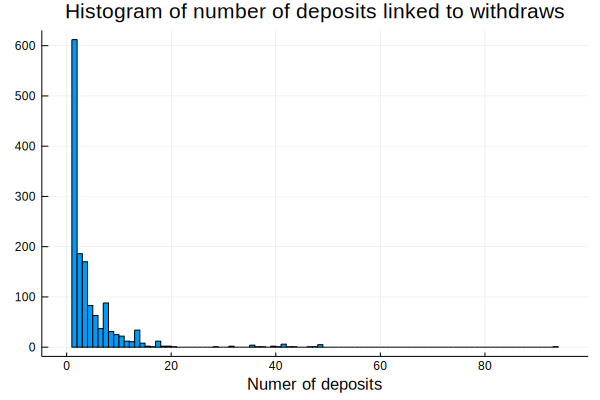

In [71]:
histogram(linked_deposits_count, bins=100, legend=false,
    title="Histogram of number of deposits linked to withdraws",
    xlabel="Numer of deposits")